In [166]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from sklearn.naive_bayes import GaussianNB

# Data Set Up

In [392]:
df = pd.read_csv('/Users/kelianneheinz/MIDS/courses/W210_Capstone/model2_results.csv')
df.head()

,Filename,blendshapes,landmarks,Pose,Face Obstructed,Hands on Face,Notes,Creator,Gender,Apparent_Race
0,aug-Pose_2_Face-Yoga-Method_416.jpg,"[7.1687679792376e-07, 0.0015940895536914468, 0...","[(0.5354241728782654, 0.3942164480686188, -0.0...",2.0,0.0,0.0,NaN,Face-Yoga-Method,F,Asian
1,zoom-Pose_2_Face-Yoga-Method_416.jpg,"[9.191711001221847e-07, 0.0002983348094858229,...","[(0.46912822127342224, 0.2676655948162079, -0....",2.0,0.0,0.0,NaN,Face-Yoga-Method,F,Asian
2,shear-Pose_2_Face-Yoga-Method_416.jpg,"[4.570634928313666e-07, 0.0008711821283213794,...","[(0.4749401807785034, 0.40972456336021423, -0....",2.0,0.0,0.0,NaN,Face-Yoga-Method,F,Asian
3,zoom-Pose_2_Face-Yoga-Method_417.jpg,"[1.2624046803466626e-06, 0.0002172658132622018...","[(0.4661442041397095, 0.2637966573238373, -0.0...",2.0,0.0,0.0,NaN,Face-Yoga-Method,F,Asian
4,flip-Pose_2_Face-Yoga-Method_415.jpg,"[5.646483600685315e-07, 0.0006009486387483776,...","[(0.5249334573745728, 0.3435852825641632, -0.0...",2.0,0.0,0.0,NaN,Face-Yoga-Method,F,Asian


In [235]:
# Drop rows with NaN in Pose
df.dropna(subset=['Pose'], inplace=True)
Filename = df['Filename']
Creator = df['Creator']
Pose = df['Pose']
features = get_features(df)
landmarks = df.landmarks.str.replace("[", '', regex=True).str.replace("]","", regex=True).str.split("\), \(", expand=True)
landmarks[0] = landmarks[0].str.replace("(", "", regex=True).str.replace(")", "", regex=True)

<>:7: DeprecationWarning: invalid escape sequence \)
<>:7: DeprecationWarning: invalid escape sequence \)
<>:7: DeprecationWarning: invalid escape sequence \)
/var/folders/r0/k75rj2ln73xc414n150s3cxr0000gn/T/ipykernel_2117/1641234755.py:7: DeprecationWarning: invalid escape sequence \)
  landmarks = df.landmarks.str.replace("[", '', regex=True).str.replace("]","", regex=True).str.split("\), \(", expand=True)


In [237]:
# Concat filename, pose and features into one dataframe
df_save = pd.concat([Filename, Creator, Pose, features], axis=1)
df_save_landmarks = pd.concat([Filename, Creator, Pose, landmarks], axis=1)

In [238]:
df_save.to_csv('/Users/kelianneheinz/MIDS/courses/W210_Capstone/blendshape_augmented_data.csv', index=False)

In [239]:
df_save_landmarks.to_csv('/Users/kelianneheinz/MIDS/courses/W210_Capstone/landmarks_augmented_data.csv', index=False)

In [25]:
def random_undersampler(df, label='Pose'):
    """Randomly undersamples df to balance classes"""
    # Get minimum number of samples in a class
    min_samples = df[label].value_counts().min()
    df_bal = pd.DataFrame()
    for pose in df[label].unique():
        df_pose = df[df[label]==pose]
        df_pose_sample = df_pose.sample(min_samples, replace=False)
        df_bal = pd.concat([df_bal, df_pose_sample])
    return df_bal

In [393]:
# Drop rows with NaN in Pose
df.dropna(subset=['Pose'], inplace=True)

# Get Unique IDs
uid=df.Filename

# Get Creator names
creator=df.Creator

# Split out and rename belndshape features
def get_features(df):
    features = df.blendshapes.str.replace('[', '', regex=True)\
        .str.replace(']', '', regex=True).str.replace("'", '', regex=True)\
            .str.split(', ', expand=True).astype(float)
    feature_names = {
    0:'browDownLeft', 1:'browDownRight', 2:'browInnerUp', 3:'browOuterUpLeft',
    4:'browOuterUpRight', 5:'cheekPuff', 6:'cheekSquintLeft', 7:'cheekSquintRight',
    8:'eyeBlinkLeft', 9:'eyeBlinkRight', 10:'eyeLookDownLeft', 11:'eyeLookDownRight',
    12:'eyeLookInLeft', 13:'eyeLookInRight', 14:'eyeLookOutLeft', 15:'eyeLookOutRight',
    16:'eyeLookUpLeft', 17:'eyeLookUpRight', 18:'eyeSquintLeft', 19:'eyeSquintRight',
    20:'eyeWideLeft', 21:'eyeWideRight', 22:'jawForward', 23:'jawLeft',
    24:'jawOpen', 25:'jawRight', 26:'mouthClose', 27:'mouthDimpleLeft',
    28:'mouthDimpleRight', 29:'mouthFrownLeft', 30:'mouthFrownRight',
    31:'mouthFunnel', 32:'mouthLeft', 33:'mouthLowerDownLeft',
    34:'mouthLowerDownRight', 35:'mouthPressLeft', 36:'mouthPressRight',
    37:'mouthPucker', 38:'mouthRight', 39:'mouthRollLower', 40:'mouthRollUpper',
    41:'mouthShrugLower', 42:'mouthShrugUpper', 43:'mouthSmileLeft',
    44:'mouthSmileRight', 45:'mouthStretchLeft', 46:'mouthStretchRight',
    47:'mouthUpperUpLeft', 48:'mouthUpperUpRight', 49:'noseSneerLeft',
    50:'noseSneerRight', 51:'tongueOut'
    }
    features.rename(columns=feature_names, inplace=True)
    return features

# Split out labels
def get_labels(df):
    labels = df.Pose.astype(int)
    return labels


In [403]:
# Take out pose 7 with hands on face
df = df[~((df.Pose == 7) & (df['Hands on Face'] == 1))]

# Test and Train Split

In [404]:
train_creators = ['AVA-LEE', 'Accents-Way-English', 'Adam-Fields-DC',
                  'Brett-Maverick', 'Brian-Abelson', 'Club-marea-oficial',
                  'Daniela-Suarez', 'Elemental-Face-Yoga', 'Elvin-ile-Yoga',
                  'En-Casa-Contigo', 'Ergotopia', 'FACEROBICS', 'Face-Up',
                  'Face-Yoga-Expert', 'Face-Yoga-Method', 'Facial-Yoga-Plan',
                  'FacialUP!', 'Fit-Eagles', 'Funfitt-with-Susana-Yabar',
                  'Gabriela-Litschi', 'Glowinface', 'HisDream', 'IBC-Mangai',
                  'IBC-Mangai-L', 'IBC-Mangai-R', 'Instituto-Yvette-pons',
                  'Khichi-Beauty', 'Lakshya-Junction', 'LibertadDigital',
                  'MIZI', 'Masumi-Channel', 'Muscle-Watching-R', 'NIVEA-espana',
                  'OppServe', 'Qi-Medicine-Acupunture', 'Shraddhas-Tapperz-Dance',
                  'Sientete-Bien', 'Stylecraze-Fitness', 'The-Uma-Show',
                  'TrabajaTuCuerpo', 'Valentina-Sadak', 'Verena-Boix', 'Yoga-Face',
                  'Yoga-with-Souvik', 'isaac-yiu', 'isasaweis', 'thefaceyogalab']

test_creators = ['Anna-Veronika', 'Blush-with-me-Parmita', 'Doctora-Claudia-Garcia',
                 'Gesund-durchs-Leben', 'Goldbeauty', 'Muscle-Watching-L', 'Natty',
                 'Pilates-by-Lisa', 'Shanthi-Kasiraj', 'Siddhi-yoga-hindi',
                 'templo-del-masaje']


In [405]:
df_train = (df[~df.Creator.isin(test_creators)])
df_train = random_undersampler(df_train)
df_test = df[df.Creator.isin(test_creators)]

In [1]:
df.head()

NameError: name 'df' is not defined

## Test and Train Visualizations

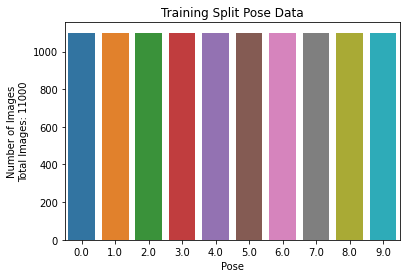

In [61]:
# Plot count of each pose in training set
ax = sns.countplot(x="Pose", data=df_train)
ax.set_title('Training Split Pose Data')
plt.xlabel('Pose')
plt.ylabel(f"Number of Images\nTotal Images: {len(df_train)}")
plt.show()

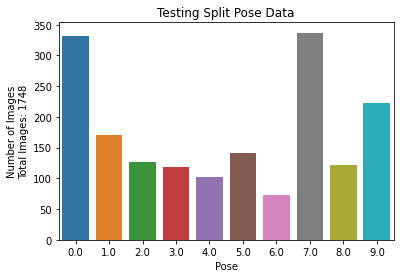

In [108]:
# Plot count of each pose in testing set
ax = sns.countplot(x="Pose", data=df_test)
ax.set_title('Testing Split Pose Data')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_test)}')
plt.show()

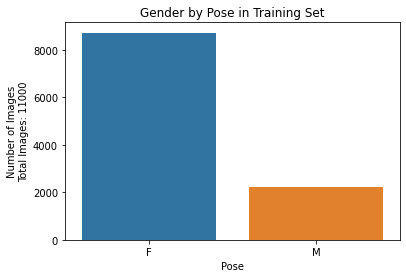

In [62]:
# Plot gender data for training set
ax = sns.countplot(x='Gender', data=df_train, order=['F', 'M'])
ax.set_title('Gender by Pose in Training Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_train)}')
plt.show()

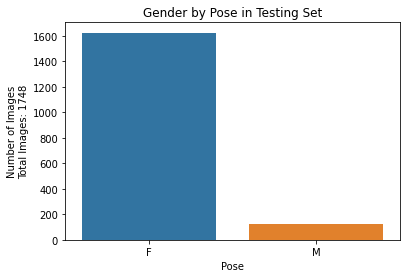

In [110]:
# Plot gender data for testing set
ax = sns.countplot(x='Gender', data=df_test, order=['F', 'M'])
ax.set_title('Gender by Pose in Testing Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_test)}')
plt.show()

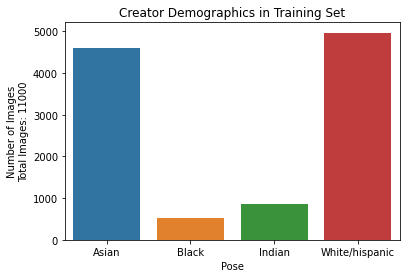

In [63]:
# Plot demographic data for training set
order = ['Asian', 'Black', 'Indian', 'White/hispanic']
ax = sns.countplot(x='Apparent_Race', data=df_train, order=order)
ax.set_title('Creator Demographics in Training Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_train)}')
plt.show()

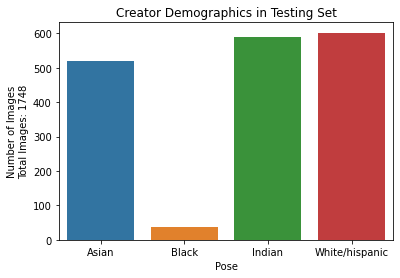

In [64]:
# Plot racial data for testing set
ax = sns.countplot(x='Apparent_Race', data=df_test, order=order)
ax.set_title('Creator Demographics in Testing Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_test)}')
plt.show()

### Further breakdown

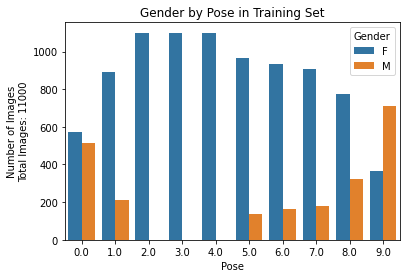

In [65]:
# Plot gender data for training set
ax = sns.countplot(x='Pose', hue='Gender', data=df_train, hue_order=['F', 'M'])
ax.set_title('Gender by Pose in Training Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_train)}')
plt.show()

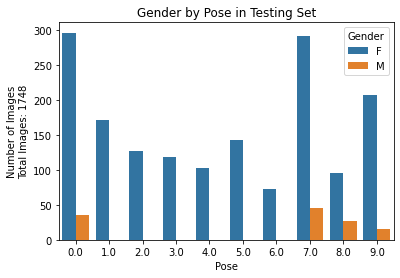

In [66]:
# Plot gender data for testing set
ax = sns.countplot(x='Pose', hue='Gender', data=df_test, hue_order=['F', 'M'])
ax.set_title('Gender by Pose in Testing Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_test)}')
plt.show()

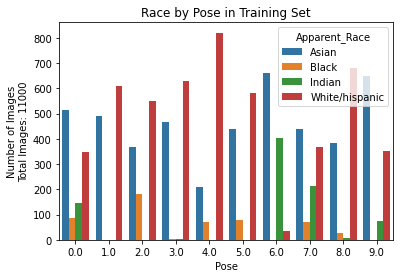

In [67]:
# Plot demographic data for training set by pose
order = ['Asian', 'Black', 'Indian', 'White/hispanic']
ax = sns.countplot(x='Pose',hue='Apparent_Race', data=df_train, hue_order=order)
ax.set_title('Race by Pose in Training Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_train)}')
plt.show()

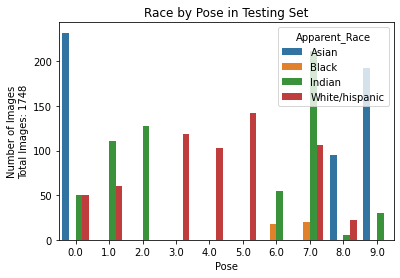

In [68]:
# Plot racial data for testing set
ax = sns.countplot(x='Pose', hue='Apparent_Race', data=df_test, hue_order=order)
ax.set_title('Race by Pose in Testing Set')
plt.xlabel('Pose')
plt.ylabel(f'Number of Images\nTotal Images: {len(df_test)}')
plt.show()

# Modeling

In [377]:
min = X_train.browDownLeft.min()
max = X_train.browDownLeft.max()
np.linspace(min, max, num=5)
# print(max)

array([5.91014127e-09, 4.11383314e-05, 8.22707526e-05, 1.23403174e-04,
       1.64535595e-04])

In [381]:
def convert_to_indicators(df_train, df_test):
    df_train_cat = df_train.copy()
    df_test_cat = df_test.copy()
    for column in df_train.columns:
        column_mean = df_train[column].mean()
        column_std = df_train[column].std()
        
        df_train_cat[column] = df_train_cat[column].apply(lambda x: 1 if x <= column_mean - column_std else
                                              2 if x <= column_mean - (column_std/2) else
                                              3 if x <= column_mean else
                                              5 if x >= column_mean + column_std else
                                              4 if x >= column_mean + (column_std/2) else 3)
        
        df_test_cat[column] = df_test_cat[column].apply(lambda x: 1 if x <= column_mean - column_std else
                                              2 if x <= column_mean - (column_std/2) else
                                              3 if x <= column_mean else
                                              5 if x >= column_mean + column_std else
                                              4 if x >= column_mean + (column_std/2) else 3)
    return df_train_cat.astype('category'), df_test_cat.astype('category')

# def convert_to_indicators(df_train, df_test):
#     df_train_cat = df_train.copy()
#     df_test_cat = df_test.copy()
#     for column in df_train.columns:
#         column_min = df_train[column].min()
#         column_max = df_train[column].max()
#         splits = np.linspace(column_min, column_max, num=5)

        
#         df_train_cat[column] = df_train_cat[column].apply(lambda x: 1 if x <= splits[0] else
#                                               2 if x <= splits[1] else
#                                               3 if x <= splits[2] else
#                                               4 if x <= splits[3] else
#                                               5)
        
#         df_test_cat[column] = df_test_cat[column].apply(lambda x: 1 if x <= splits[0] else
#                                               2 if x <= splits[1] else
#                                               3 if x <= splits[2] else
#                                               4 if x <= splits[3] else
#                                               5)
#     return df_train_cat.astype('category'), df_test_cat.astype('category')

In [385]:
X_train_cat, X_test_cat = convert_to_indicators(pd.DataFrame(X_train_scaled), pd.DataFrame(X_test_scaled))
# X_test_cat = convert_to_indicators(X_test).astype('category')

In [384]:
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.608054,-0.286338,0.425797,-1.269087,0.804632,-1.181501,1.131605,-0.009639,0.662633,-0.884561,...,-0.415263,-0.203584,-0.271554,-0.081195,1.479829,8.853875,-0.355964,-0.365709,0.589622,0.277732
1,0.309753,-0.300498,-0.291410,-0.290234,-0.032091,0.313047,4.426574,1.001729,1.088719,-0.714552,...,-0.406822,0.120007,2.733667,2.569087,0.678202,0.253991,2.661275,1.893878,0.047720,4.713656
2,0.846442,0.117085,-0.255768,-1.246177,-1.220204,1.145129,2.820320,0.883953,1.281724,-0.606144,...,-0.410180,-0.204642,3.100719,3.041834,3.060059,1.278440,0.160572,0.030785,-0.088715,2.738899
3,-0.085854,-0.342589,-0.311775,2.019708,1.654366,1.172394,-0.256365,1.082125,-0.023034,-0.827609,...,-0.385795,-0.130679,-0.489676,-0.492812,-0.337033,-0.292638,-0.205635,-0.275648,3.324422,-0.172255
4,-0.251997,-0.341186,-0.312212,1.577044,0.904006,0.247582,1.916607,0.926028,-0.010576,0.300390,...,-0.413303,-0.299411,1.764534,1.403070,-0.258421,0.299563,1.217563,0.705078,-0.141249,1.259179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10995,0.073487,-0.332057,-0.291425,1.234773,0.703491,0.494277,-0.476183,-0.294784,0.013819,-0.822114,...,-0.411435,-0.335179,-0.489726,-0.492849,-0.341759,-0.346375,-0.362287,-0.374873,-0.015475,-0.540852
10996,-0.154733,-0.325773,-0.286626,-0.334799,-0.316763,-0.267406,-0.523171,-0.358915,-0.497119,-0.026700,...,1.557652,-0.069080,-0.489724,-0.492848,-0.341750,-0.346360,-0.361851,-0.374608,-0.302161,-0.526631
10997,-0.192066,-0.088757,-0.295286,-0.438937,-0.886665,1.140687,-0.513093,-0.345718,-0.426416,-0.633246,...,-0.410374,-0.335835,-0.489726,-0.492849,-0.341758,-0.346504,-0.362288,-0.374860,-0.333460,-0.557031
10998,0.108674,-0.302434,-0.289496,0.268662,-0.339014,1.145347,-0.499880,0.046903,0.965408,-0.740132,...,-0.363461,-0.288897,-0.489725,-0.492849,-0.341740,-0.334078,-0.362055,-0.374809,1.765748,-0.307695


In [295]:
X_train_cat = X_train_cat.astype('category')

In [283]:
X_test_cat = X_test > train_avg_dict
# X_test_cat = to_categorical(X_test_cat)

In [ ]:
# Change values in X_train to 1 if < mean - std, 3 if > mean + std, 2 else
X_train.apply()

In [406]:
# Creator based feature split
# X_train = features[creator.isin(train_creators)]
# X_test = features[creator.isin(test_creators)]
X_train = get_features(df_train)
X_test = get_features(df_test)



In [407]:
# Scaled features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creator based label split
# y_train = labels[creator.isin(train_creators)]
y_train = get_labels(df_train)
y_train_categorical = to_categorical(y_train)
# y_test = labels[creator.isin(test_creators)]
y_test = get_labels(df_test)
y_test_categorical = to_categorical(y_test)

# # Random split
# X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, labels, test_size=0.25, random_state=42)
# y_train_rand_categorical = to_categorical(y_train_rand)
# y_test_rand_categorical = to_categorical(y_test_rand)

In [160]:
X_train['browDown'] = X_train['browDownLeft'] * X_train['browDownRight']
X_train['browOututerUp'] = X_train['browOuterUpLeft'] * X_train['browOuterUpRight']
X_train['cheekSquint'] = X_train['cheekSquintLeft'] * X_train['cheekSquintRight']
X_train['eyeWide'] = X_train['eyeWideLeft'] * X_train['eyeWideRight']
X_train['eyeBlink'] = X_train['eyeBlinkLeft'] * X_train['eyeBlinkRight']
X_train['eyeDown'] = X_train['eyeLookDownLeft'] * X_train['eyeLookDownRight']
X_train['eyeLookUp'] = X_train['eyeLookUpLeft'] * X_train['eyeLookUpRight']
X_train['eyeSquint'] = X_train['eyeSquintLeft'] * X_train['eyeSquintRight']
X_train['jawSide'] = X_train['jawLeft'] * X_train['jawRight']
X_train['mouthDimple'] = X_train['mouthDimpleLeft'] * X_train['mouthDimpleRight']
X_train['mouthLowerDown'] = X_train['mouthLowerDownLeft'] * X_train['mouthLowerDownRight']
X_train['mouthPress'] = X_train['mouthPressLeft'] * X_train['mouthPressRight']
X_train['mouthSmile'] = X_train['mouthSmileLeft'] * X_train['mouthSmileRight']
X_train['mouthStretch'] = X_train['mouthStretchLeft'] * X_train['mouthStretchRight']
X_train['mouthUpperUp'] = X_train['mouthUpperUpLeft'] * X_train['mouthUpperUpRight']
X_train['noseSneer'] = X_train['noseSneerLeft'] * X_train['noseSneerRight']

In [161]:
X_test['browDown'] = X_test['browDownLeft'] * X_test['browDownRight']
X_test['browOututerUp'] = X_test['browOuterUpLeft'] * X_test['browOuterUpRight']
X_test['cheekSquint'] = X_test['cheekSquintLeft'] * X_test['cheekSquintRight']
X_test['eyeWide'] = X_test['eyeWideLeft'] * X_test['eyeWideRight']
X_test['eyeBlink'] = X_test['eyeBlinkLeft'] * X_test['eyeBlinkRight']
X_test['eyeDown'] = X_test['eyeLookDownLeft'] * X_test['eyeLookDownRight']
X_test['eyeLookUp'] = X_test['eyeLookUpLeft'] * X_test['eyeLookUpRight']
X_test['eyeSquint'] = X_test['eyeSquintLeft'] * X_test['eyeSquintRight']
X_test['jawSide'] = X_test['jawLeft'] * X_test['jawRight']
X_test['mouthDimple'] = X_test['mouthDimpleLeft'] * X_test['mouthDimpleRight']
X_test['mouthLowerDown'] = X_test['mouthLowerDownLeft'] * X_test['mouthLowerDownRight']
X_test['mouthPress'] = X_test['mouthPressLeft'] * X_test['mouthPressRight']
X_test['mouthSmile'] = X_test['mouthSmileLeft'] * X_test['mouthSmileRight']
X_test['mouthStretch'] = X_test['mouthStretchLeft'] * X_test['mouthStretchRight']
X_test['mouthUpperUp'] = X_test['mouthUpperUpLeft'] * X_test['mouthUpperUpRight']
X_test['noseSneer'] = X_test['noseSneerLeft'] * X_test['noseSneerRight']

In [36]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

In [38]:
model_storage = {}

## Feature Engineering

In [59]:
from autofeat import FeatureSelector, AutoFeatRegressor

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 52 features.
[AutoFeat] With 11000 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 44 features after 5 feature selection runs
[featsel] 38 features after correlation filtering
[featsel] 5 features after noise filtering
[AutoFeat] Final dataframe with 52 feature columns (0 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
3.4275278938634286
5.514152 * mouthLeft
4.530208 * mouthFrownLeft
-3.034781 * noseSneerLeft
1.994602 * mouthRight
-0.874881 * mouthSmileRight
[AutoFeat] Final score: 0.3310
## Final R^2: 0.3310
### AutoFeat with 1 feateng

KeyboardInterrupt: 

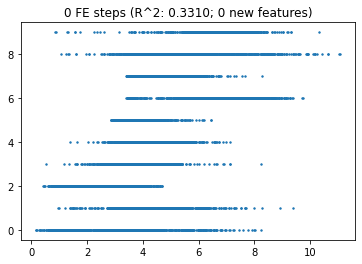

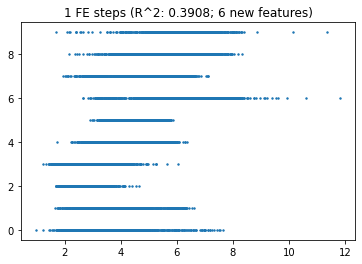

In [60]:
for steps in range(4):
    np.random.seed(55)
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1, feateng_steps=steps)
    df = afreg.fit_transform(X_train, y_train)
    r2 = afreg.score(X_train, y_train)
    print("## Final R^2: %.4f" % r2)
    plt.figure()
    plt.scatter(afreg.predict(X_train), y_train, s=2)
    plt.title("%i FE steps (R^2: %.4f; %i new features)" % (steps, r2, len(afreg.new_feat_cols_)))

In [132]:
from featurewiz import FeatureWiz
features = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = features.fit_transform(X_train, y_train)
X_test_selected = features.transform(X_test)
features.features  # the selected feature list #
# automated feature generation
import featurewiz as FW
outputs = FW.featurewiz(dataname=X_train_selected, target=X_test_selected, corr_limit=0.70, verbose=2, sep=',', 
                header=0, test_data='',feature_engg='', category_encoders='',
                dask_xgboost_flag=False, nrows=None)

OSError: dlopen(/Users/kelianneheinz/opt/anaconda3/envs/myvenv/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: '/usr/local/opt/libomp/lib/libomp.dylib'
  Referenced from: '/Users/kelianneheinz/opt/anaconda3/envs/myvenv/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so'
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

## Logistic Regression

In [130]:
from sklearn.decomposition import PCA

In [135]:
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train)
pca.n_components_
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)


In [390]:
X_train_cat[0].value_counts()

3    9826
5     730
4     444
Name: 0, dtype: int64

In [335]:
X_train.browDownLeft.value_counts()

1.618120e-06    2
3.164216e-06    2
6.180985e-07    2
2.278847e-07    2
5.247470e-07    2
               ..
2.774424e-06    1
2.580514e-07    1
1.460689e-06    1
8.743650e-07    1
1.710104e-06    1
Name: browDownLeft, Length: 10987, dtype: int64

In [370]:
X_train_cat

,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,browOuterUpRight,cheekPuff,cheekSquintLeft,cheekSquintRight,eyeBlinkLeft,eyeBlinkRight,...,mouthShrugUpper,mouthSmileLeft,mouthSmileRight,mouthStretchLeft,mouthStretchRight,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight,tongueOut
5176,4,3,3,1,4,1,5,3,4,2,...,3,3,3,3,5,5,3,3,4,3
5640,3,3,3,3,3,3,5,5,5,2,...,3,3,5,5,4,3,5,5,3,5
5758,4,3,3,1,1,5,5,4,5,2,...,3,3,5,5,5,5,3,3,3,5
35,3,3,3,5,5,5,3,5,3,2,...,3,3,3,3,3,3,3,3,5,3
5936,3,3,3,5,4,3,5,4,3,3,...,3,3,5,5,3,3,5,4,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,3,3,3,5,4,3,3,3,3,2,...,3,3,3,3,3,3,3,3,3,2
12176,3,3,3,3,3,3,2,3,3,3,...,5,3,3,3,3,3,3,3,3,2
12613,3,3,3,3,2,5,2,3,3,2,...,3,3,3,3,3,3,3,3,3,2
10863,3,3,3,3,3,5,3,3,4,2,...,3,3,3,3,3,3,3,3,5,3


In [380]:
X_train_cat.browDownLeft.value_counts()

2    10991
3        5
5        2
1        1
4        1
Name: browDownLeft, dtype: int64

In [391]:
# Creator Based Test/Train Split
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
lr.fit(X_train_cat, y_train)
y_pred = lr.predict(X_test_cat)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
model_storage['LR - Creator Split'] = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
# print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Logistic Regression Accuracy: 0.6733409610983981
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       332
           1       0.58      0.33      0.42       171
           2       0.68      0.76      0.72       127
           3       0.66      0.96      0.78       119
           4       0.92      0.82      0.87       103
           5       0.89      0.92      0.91       142
           6       0.36      0.59      0.45        73
           7       0.51      0.49      0.50       337
           8       0.74      0.84      0.79       122
           9       0.78      0.68      0.73       222

    accuracy                           0.67      1748
   macro avg       0.68      0.71      0.69      1748
weighted avg       0.68      0.67      0.67      1748

[[232  20  36   7   0   5   2  22   3   5]
 [ 11  57   0  18   0   0   0  85   0   0]
 [  2   0  97   0   0   0   0   0  28   0]
 [  1   3   0 114   0   0   0   1   0   

In [348]:
X_train.round(5)

,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,browOuterUpRight,cheekPuff,cheekSquintLeft,cheekSquintRight,eyeBlinkLeft,eyeBlinkRight,...,mouthShrugUpper,mouthSmileLeft,mouthSmileRight,mouthStretchLeft,mouthStretchRight,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight,tongueOut
5176,0.00000,0.00474,0.03128,0.00530,0.59535,0.09504,0.00063,0.0,0.0,0.00158,...,0.00050,0.01593,0.05030,0.09870,0.16465,0.82258,0.00092,0.00158,0.00001,0.00000
5640,0.00000,0.00357,0.00095,0.26514,0.37658,0.48852,0.00186,0.0,0.0,0.03541,...,0.00218,0.05334,0.74317,0.73412,0.09219,0.05369,0.44073,0.39089,0.00000,0.00001
5758,0.00001,0.03813,0.00246,0.01138,0.06592,0.70759,0.00126,0.0,0.0,0.05698,...,0.00151,0.01581,0.82779,0.84746,0.30749,0.14528,0.07622,0.06989,0.00000,0.00001
35,0.00000,0.00009,0.00009,0.87834,0.81753,0.71477,0.00011,0.0,0.0,0.01291,...,0.00639,0.02436,0.00001,0.00001,0.00043,0.00482,0.02284,0.01710,0.00004,0.00000
5936,0.00000,0.00020,0.00007,0.76083,0.62133,0.47129,0.00092,0.0,0.0,0.23738,...,0.00089,0.00486,0.51973,0.45456,0.00753,0.05776,0.23029,0.18607,0.00000,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12688,0.00000,0.00096,0.00095,0.66997,0.56891,0.53624,0.00002,0.0,0.0,0.01400,...,0.00126,0.00072,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000
12176,0.00000,0.00148,0.00115,0.25331,0.30214,0.33570,0.00001,0.0,0.0,0.17229,...,0.39511,0.03148,0.00000,0.00000,0.00000,0.00001,0.00007,0.00005,0.00000,0.00000
12613,0.00000,0.02110,0.00078,0.22567,0.15313,0.70642,0.00001,0.0,0.0,0.05159,...,0.00147,0.00065,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
10863,0.00000,0.00341,0.00103,0.41351,0.29633,0.70765,0.00001,0.0,0.0,0.03032,...,0.01086,0.00607,0.00000,0.00000,0.00000,0.00111,0.00004,0.00001,0.00002,0.00000


In [409]:
# Creator Based Test/Train Split
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
model_storage['LR - Creator Split'] = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
# print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

Logistic Regression Accuracy: 0.7219512195121951
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       332
           1       0.79      0.68      0.73       171
           2       0.68      0.87      0.77       127
           3       0.73      0.96      0.83       119
           4       0.91      0.83      0.87       103
           5       0.88      0.94      0.91       142
           6       0.26      0.34      0.29        73
           7       0.60      0.46      0.52       229
           8       0.81      0.87      0.84       122
           9       0.80      0.68      0.73       222

    accuracy                           0.72      1640
   macro avg       0.72      0.74      0.72      1640
weighted avg       0.73      0.72      0.72      1640

[[236  15  48   9   3   7   1   8   1   4]
 [ 18 117   0   0   0   0  29   7   0   0]
 [  4   0 111   0   0   0   0   0  12   0]
 [  4   1   0 114   0   0   0   0   0   

In [46]:
# Train an SPE classifier
import imbalanced_ensemble
from imbalanced_ensemble.ensemble import SelfPacedEnsembleClassifier
clf = SelfPacedEnsembleClassifier(random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict with an SPE classifier
y_pred = clf.predict(X_test_scaled)

In [48]:
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Logistic Regression Accuracy: 0.5892448512585813
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       332
           1       0.22      0.10      0.14       171
           2       0.78      0.85      0.81       127
           3       0.64      0.81      0.72       119
           4       0.92      0.59      0.72       103
           5       0.90      0.91      0.90       142
           6       0.15      0.38      0.21        73
           7       0.61      0.44      0.51       337
           8       0.77      0.84      0.80       122
           9       0.53      0.47      0.50       222

    accuracy                           0.59      1748
   macro avg       0.61      0.61      0.60      1748
weighted avg       0.60      0.59      0.58      1748



In [19]:
# Random Test/Train Split
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
lr.fit(X_train_rand, y_train_rand)
y_pred = lr.predict(X_test_rand)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test_rand, y_pred)}')
model_storage['LR - Rand Split'] = classification_report(y_test_rand, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test_rand, y_pred)}")

Logistic Regression Accuracy: 0.7971284996410625
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      1227
           1       0.64      0.58      0.61       581
           2       0.90      0.91      0.91       541
           3       0.90      0.92      0.91       540
           4       0.81      0.79      0.80       520
           5       0.94      0.91      0.93       549
           6       0.82      0.63      0.71       317
           7       0.74      0.86      0.80      1014
           8       0.88      0.92      0.90       854
           9       0.74      0.85      0.79       822

    accuracy                           0.80      6965
   macro avg       0.81      0.80      0.80      6965
weighted avg       0.80      0.80      0.79      6965



## NN 

In [342]:
# Creator Based Test/Train Split
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_cat.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_cat, y_train_categorical, epochs=20, batch_size=64, validation_data=(X_test_cat, y_test_categorical))

# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_cat, y_test_categorical, verbose=2)
print(f"Creator Split Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

# Get classification report
y_pred = model.predict(X_test_cat)
y_pred = y_pred.argmax(axis=1)
model_storage['NN - Creator Split'] = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Epoch 1/20
172/172 [==============================] - 2s 4ms/step - loss: 3.8514 - accuracy: 0.5912 - val_loss: 3.6237 - val_accuracy: 0.3604
Epoch 2/20
172/172 [==============================] - 0s 3ms/step - loss: 2.4425 - accuracy: 0.7397 - val_loss: 2.2994 - val_accuracy: 0.6276
Epoch 3/20
172/172 [==============================] - 0s 3ms/step - loss: 1.8159 - accuracy: 0.7662 - val_loss: 1.7877 - val_accuracy: 0.7008
Epoch 4/20
172/172 [==============================] - 0s 3ms/step - loss: 1.4204 - accuracy: 0.7870 - val_loss: 1.5064 - val_accuracy: 0.7122
Epoch 5/20
172/172 [==============================] - 0s 3ms/step - loss: 1.2138 - accuracy: 0.7850 - val_loss: 1.4864 - val_accuracy: 0.6756
Epoch 6/20
172/172 [==============================] - 0s 3ms/step - loss: 1.0508 - accuracy: 0.7945 - val_loss: 1.3933 - val_accuracy: 0.6625
Epoch 7/20
172/172 [==============================] - 0s 3ms/step - loss: 0.9440 - accuracy: 0.8031 - val_loss: 1.4143 - val_accuracy: 0.6201
Epoch 

In [65]:
# Random Based Test/Train Split
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_rand.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y_train_rand)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=32, validation_data=(X_test_rand, y_test_rand_categorical))

# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_rand, y_test_rand_categorical, verbose=2)
print(f"Random Split Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

# Get classification report
y_pred = model.predict(X_test_rand)
y_pred = y_pred.argmax(axis=1)
model_storage['NN - Random Split'] = classification_report(y_test_rand, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test_rand, y_pred)}")


Epoch 1/100
166/166 [==============================] - 2s 5ms/step - loss: 4.2556 - accuracy: 0.5669 - val_loss: 4.4842 - val_accuracy: 0.1380
Epoch 2/100
166/166 [==============================] - 1s 4ms/step - loss: 2.8923 - accuracy: 0.7509 - val_loss: 3.4332 - val_accuracy: 0.4151
Epoch 3/100
166/166 [==============================] - 1s 4ms/step - loss: 2.2013 - accuracy: 0.7873 - val_loss: 2.2042 - val_accuracy: 0.6701
Epoch 4/100
166/166 [==============================] - 1s 4ms/step - loss: 1.7447 - accuracy: 0.8013 - val_loss: 1.5658 - val_accuracy: 0.8279
Epoch 5/100
166/166 [==============================] - 1s 3ms/step - loss: 1.4352 - accuracy: 0.8181 - val_loss: 1.2812 - val_accuracy: 0.8268
Epoch 6/100
166/166 [==============================] - 1s 5ms/step - loss: 1.2215 - accuracy: 0.8285 - val_loss: 1.1862 - val_accuracy: 0.8132
Epoch 7/100
166/166 [==============================] - 1s 4ms/step - loss: 1.0709 - accuracy: 0.8379 - val_loss: 1.0603 - val_accuracy: 0.8217

# Random Forest

In [343]:
# Creator Based Test/Train Split
rf = RandomForestClassifier(n_estimators=250, max_depth = 8, random_state=42)
rf.fit(X_train_cat, y_train)
y_pred = rf.predict(X_test_cat)
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred)}')
model_storage['RF - Creator Split'] = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Random Forest Accuracy: 0.6435926773455377
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.64      0.76       332
           1       0.54      0.35      0.42       171
           2       0.83      0.98      0.90       127
           3       0.39      0.93      0.55       119
           4       0.99      0.70      0.82       103
           5       0.79      0.97      0.87       142
           6       0.32      0.42      0.36        73
           7       0.42      0.36      0.39       337
           8       0.84      0.83      0.83       122
           9       0.71      0.68      0.69       222

    accuracy                           0.64      1748
   macro avg       0.68      0.69      0.66      1748
weighted avg       0.68      0.64      0.64      1748



In [289]:
# Random Based Test/Train Split
rf = RandomForestClassifier(n_estimators=250, max_depth = 8, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Random Forest Accuracy: {accuracy_score(y_test, y_pred)}')
# model_storage['RF - Random Split'] = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Random Forest Accuracy: 0.6767734553775744
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       332
           1       0.60      0.41      0.49       171
           2       0.80      0.96      0.87       127
           3       0.63      0.96      0.76       119
           4       0.98      0.53      0.69       103
           5       0.94      0.96      0.95       142
           6       0.24      0.34      0.28        73
           7       0.50      0.46      0.48       337
           8       0.93      0.87      0.90       122
           9       0.62      0.65      0.64       222

    accuracy                           0.68      1748
   macro avg       0.70      0.69      0.68      1748
weighted avg       0.69      0.68      0.67      1748



# Gaussian Naive Bayes

In [345]:
# GNB with Creator based test/train split
gnb = GaussianNB()
gnb.fit(X_train_cat, y_train)
y_pred = gnb.predict(X_test_cat)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_score(y_test, y_pred)}')
model_storage['GNB - Creator Split'] = classification_report(y_test, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Gaussian Naive Bayes Accuracy: 0.28718535469107553
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.03      0.06       332
           1       0.00      0.00      0.00       171
           2       0.36      1.00      0.53       127
           3       0.78      0.59      0.67       119
           4       0.84      0.16      0.26       103
           5       0.50      0.89      0.64       142
           6       0.03      0.26      0.05        73
           7       0.43      0.33      0.37       337
           8       0.88      0.17      0.29       122
           9       0.02      0.00      0.01       222

    accuracy                           0.29      1748
   macro avg       0.44      0.34      0.29      1748
weighted avg       0.42      0.29      0.26      1748



In [72]:
# GNB with Random based test/train split
gnb = GaussianNB()
gnb.fit(X_train_rand, y_train_rand)
y_pred = gnb.predict(X_test_rand)
print(f'Gaussian Naive Bayes Accuracy: {accuracy_score(y_test_rand, y_pred)}')
model_storage['GNB - Random Split'] = classification_report(y_test_rand, y_pred, output_dict=True)
print(f"Classification Report:\n{classification_report(y_test_rand, y_pred)}")

Gaussian Naive Bayes Accuracy: 0.5587734241908007
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.41      0.55       321
           1       0.54      0.30      0.38       161
           2       0.76      0.97      0.85       139
           3       0.83      0.69      0.75       130
           4       0.68      0.85      0.76       120
           5       0.68      0.95      0.79       133
           6       0.16      0.89      0.27        74
           7       0.46      0.48      0.47       266
           8       0.84      0.53      0.65       190
           9       0.71      0.24      0.36       227

    accuracy                           0.56      1761
   macro avg       0.65      0.63      0.58      1761
weighted avg       0.68      0.56      0.57      1761



## Plot Comparisons

In [61]:
# Make dictionaries to color/shape code results
color_dict = {key: ('r' if "LR" in key else 'g' if "RF" in key else 'b' if "GNB" in key else 'y') for key in model_storage.keys()}
marker_dict = {key: ("o" if "Creator" in key else "x") for key in model_storage.keys()}

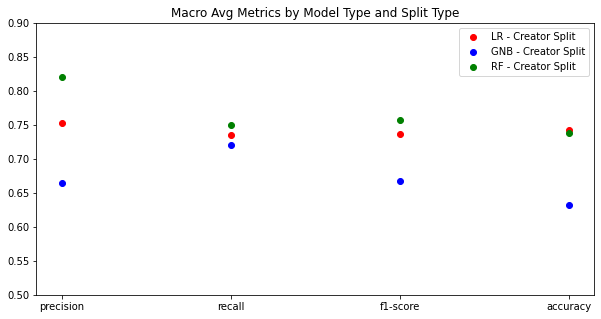

In [62]:
x_keys = ['precision', 'recall', 'f1-score']
x_ticks = x_keys + ['accuracy']
for key in model_storage.keys():
    y_plot = []
    for i in x_keys:
        y_plot.append(model_storage[key]['macro avg'][i])
    y_plot.append(model_storage[key]['accuracy'])
    plt.scatter(x_ticks, y_plot, marker=marker_dict[key], color=color_dict[key], label=key)
plt.legend(model_storage.keys())
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title('Macro Avg Metrics by Model Type and Split Type')
plt.yticks(np.arange(0.5, 0.95, step=0.05))
plt.show()

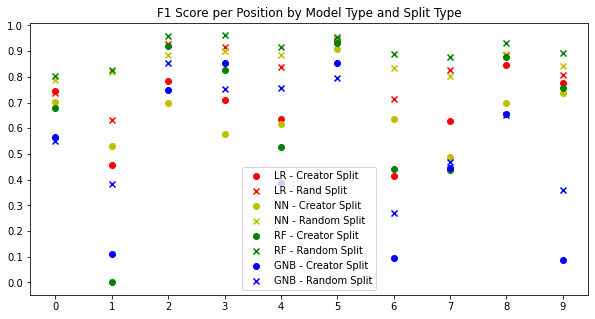

In [166]:
for key in model_storage.keys():
    f1 = []
    y_val = []
    for i in range(0,10):
        f1.append(model_storage[key][str(i)]['f1-score'])
        y_val.append(i)
    plt.scatter(y_val, f1, label=key, marker=marker_dict[key], color=color_dict[key])
plt.xticks(y_val)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title('F1 Score per Position by Model Type and Split Type')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend()


## Jing's CNN

In [137]:
X_train

,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,browOuterUpRight,cheekPuff,cheekSquintLeft,cheekSquintRight,eyeBlinkLeft,eyeBlinkRight,...,eyeLookUp,eyeSquint,jawSide,mouthDimple,mouthLowerDown,mouthPress,mouthSmile,mouthStretch,mouthUpperUp,noseSneer
5944,9.625447e-07,0.001544,0.000338,0.399779,0.346563,0.432508,0.000787,4.379784e-06,1.130843e-06,0.244898,...,0.003688,0.030905,0.000738,4.177094e-06,0.000958,5.838960e-03,2.169161e-03,2.062979e-02,3.035604e-02,1.426318e-06
25586,1.106558e-06,0.000238,0.000466,0.375686,0.743948,0.421425,0.000783,6.182250e-06,3.469201e-06,0.562843,...,0.000502,0.002313,0.001366,2.394194e-06,0.000059,1.187705e-02,3.626731e-04,4.484283e-03,1.450968e-01,9.595509e-06
278,6.738082e-07,0.001965,0.000670,0.309724,0.435127,0.573746,0.000547,2.403362e-06,2.172852e-06,0.033553,...,0.001215,0.026763,0.000779,6.317980e-06,0.016287,2.041208e-04,1.098766e-02,3.985059e-02,6.190585e-04,2.267148e-07
5276,1.417981e-06,0.000281,0.000235,0.434729,0.723690,0.532944,0.001621,6.762882e-06,2.730496e-06,0.512526,...,0.001161,0.009951,0.002609,4.612632e-06,0.000072,1.501014e-02,4.253981e-04,3.859809e-03,5.453854e-02,9.500350e-06
26040,1.027683e-06,0.000883,0.000386,0.640444,0.431242,0.376091,0.000988,1.140034e-05,1.659359e-06,0.239739,...,0.001023,0.007743,0.000848,4.508553e-06,0.000426,6.199311e-03,1.823684e-02,9.447431e-02,3.243348e-02,3.619254e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12693,5.425848e-07,0.008968,0.000816,0.379874,0.242444,0.646228,0.000014,1.770101e-07,2.408065e-07,0.039627,...,0.096304,0.075359,0.000015,5.115434e-03,0.001496,5.166534e-07,8.647225e-11,6.900573e-14,6.081916e-13,1.358312e-12
10866,1.059871e-07,0.000487,0.000515,0.563064,0.804954,0.461060,0.000013,3.298403e-07,7.185126e-08,0.008056,...,0.365123,0.136505,0.000001,8.093002e-07,0.001485,5.192523e-07,3.254161e-09,1.488687e-10,8.048970e-11,3.829019e-11
12565,4.979076e-07,0.022457,0.001821,0.251960,0.176725,0.395931,0.000008,3.690283e-07,3.620539e-07,0.008175,...,0.000925,0.002305,0.000003,5.405831e-04,0.000022,3.268508e-07,3.147907e-10,2.770262e-13,1.248526e-12,8.215007e-13
23564,5.164466e-07,0.000787,0.000788,0.572568,0.616935,0.594810,0.000011,2.026808e-07,3.569436e-07,0.011813,...,0.053366,0.030725,0.000007,2.702666e-02,0.000061,1.067987e-07,7.537590e-11,6.801977e-15,9.336330e-13,1.371568e-12


In [361]:
# based on best cnn augmented data
model = Sequential()
model.add(layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))
# layer 1
model.add(layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(BatchNormalization())
model.add(layers.AveragePooling1D(pool_size=2))
# layer 2
model.add(layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(BatchNormalization())
model.add(layers.AveragePooling1D(pool_size=2))
# layer 3
model.add(layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Dropout(0.3))
model.add(BatchNormalization())
model.add(layers.AveragePooling1D(pool_size=2))
#layer 4
model.add(layers.Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))

# fully connected layer 1
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# fully connected layer 2
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))

# output
model.add(layers.Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train.round(1), y_train_categorical, epochs=20, batch_size=64, validation_data=(X_test.round(1), y_test_categorical))

Epoch 1/20
172/172 [==============================] - 4s 11ms/step - loss: 3.2573 - accuracy: 0.2528 - val_loss: 3.2506 - val_accuracy: 0.0589
Epoch 2/20
172/172 [==============================] - 2s 10ms/step - loss: 2.2476 - accuracy: 0.4654 - val_loss: 3.2036 - val_accuracy: 0.0652
Epoch 3/20
172/172 [==============================] - 2s 9ms/step - loss: 1.7628 - accuracy: 0.5504 - val_loss: 2.3711 - val_accuracy: 0.2832
Epoch 4/20
172/172 [==============================] - 2s 10ms/step - loss: 1.4820 - accuracy: 0.5959 - val_loss: 1.3351 - val_accuracy: 0.6104
Epoch 5/20
172/172 [==============================] - 2s 9ms/step - loss: 1.3014 - accuracy: 0.6255 - val_loss: 1.0843 - val_accuracy: 0.6751
Epoch 6/20
172/172 [==============================] - 2s 10ms/step - loss: 1.2042 - accuracy: 0.6456 - val_loss: 1.0789 - val_accuracy: 0.6522
Epoch 7/20
172/172 [==============================] - 2s 9ms/step - loss: 1.1461 - accuracy: 0.6624 - val_loss: 1.0600 - val_accuracy: 0.6527
Ep

KeyboardInterrupt: 

In [356]:
def cnn_plot(history):
  # Plot the training accuracy and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot the training loss and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

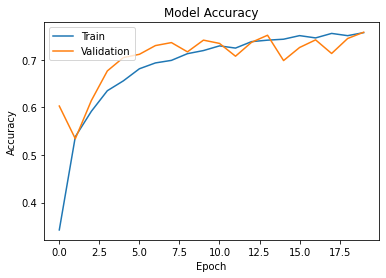

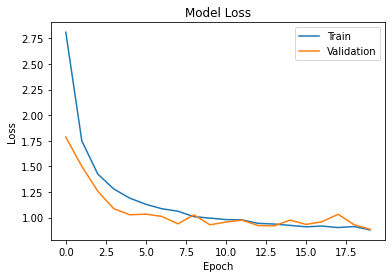

In [140]:
cnn_plot(history)

## OneVsRest Classifier

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

In [142]:
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True)).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
print(f'OneVsRestClassifier Accuracy: {accuracy_score(y_test, y_pred)}')
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


OneVsRestClassifier Accuracy: 0.7082379862700229
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       332
           1       0.61      0.46      0.52       171
           2       0.86      0.89      0.88       127
           3       0.66      0.96      0.78       119
           4       0.94      0.79      0.86       103
           5       0.94      0.96      0.95       142
           6       0.26      0.33      0.29        73
           7       0.60      0.56      0.58       337
           8       0.75      0.89      0.81       122
           9       0.86      0.70      0.77       222

    accuracy                           0.71      1748
   macro avg       0.72      0.73      0.71      1748
weighted avg       0.72      0.71      0.71      1748



## Transformers

In [73]:
!pip install pytorch_widedeep

     |████████████████████████████████| 21.1 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 33.0 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 519 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 63.1 MB 408 kB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 603 kB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 6.7 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 4.9 MB/s eta 0:00:011
     |████████████████████████████████| 844 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 489 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB

In [75]:
from pytorch_widedeep.preprocessing import TabPreprocessor

In [89]:
cont_cols = X_train.columns.tolist()

tab_preprocessor = TabPreprocessor(continuous_cols=cont_cols, scale=True)
X_tab = tab_preprocessor.fit_transform(X_train)
X_tab_test = tab_preprocessor.transform(X_test)

In [77]:
from pytorch_widedeep.models import TabMlp, WideDeep

In [87]:
tabmlp = TabMlp(
    mlp_hidden_dims=[200, 100],
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=cont_cols
)

In [90]:
model = WideDeep(deeptabular=tabmlp, pred_dim=df_train.Pose.nunique())
model

WideDeep(
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
        (cont_norm): BatchNorm1d(52, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder): MLP(
        (mlp): Sequential(
          (dense_layer_0): Sequential(
            (0): Dropout(p=0.1, inplace=False)
            (1): Linear(in_features=52, out_features=200, bias=True)
            (2): ReLU(inplace=True)
          )
          (dense_layer_1): Sequential(
            (0): Dropout(p=0.1, inplace=False)
            (1): Linear(in_features=200, out_features=100, bias=True)
            (2): ReLU(inplace=True)
          )
        )
      )
    )
    (1): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [93]:
import torchmetrics
import pytorch_widedeep

In [105]:
import numpy as np
import pandas as pd
from torch.optim import SGD, lr_scheduler

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.models import TabMlp, WideDeep
from torchmetrics import AUROC
from pytorch_widedeep.initializers import XavierNormal
from pytorch_widedeep.datasets import load_ecoli
from pytorch_widedeep.utils import LabelEncoder
from pytorch_widedeep.metrics import Accuracy

In [106]:
auroc = AUROC(num_classes=df_train.Pose.nunique(), task="multiclass")


# Optimizers
deep_opt = SGD(model.deeptabular.parameters(), lr=0.1)
# LR Scheduler
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
# Hyperparameters
trainer = Trainer(
    model,
    objective="multiclass_focal_loss",
    metrics=[(Accuracy)],
)


In [101]:
X_train_tab = {"X_tab": X_tab, "target": y_train}
X_test_tab = {"X_tab": X_tab_test, "target": y_test}

In [108]:
trainer.fit(X_train=X_train_tab, X_val=X_test_tab, n_epochs=10, batch_size=1)

epoch 1:   0%|          | 0/11000 [01:21<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 52])

In [109]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [110]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [111]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [116]:
max_len = 52

In [115]:
X_train.shape

(11000, 52)

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = nn.Linear(52, )
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
